# Module 1- Dataset importing and preprocessing

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d abdullahshafi315/indian-diabetic-retinopathy-image-datasetidrid

 96% 182M/189M [00:01<00:00, 116MB/s] 
100% 189M/189M [00:02<00:00, 98.6MB/s]


In [ ]:
!unzip -q indian-diabetic-retinopathy-image-datasetidrid.zip -d IDRiD
!rm indian-diabetic-retinopathy-image-datasetidrid.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, Xception
from keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
# Loading the dataset
df = pd.read_csv('/content/IDRiD/Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')

df['Image name'] = df['Image name'].apply(lambda x: f"/content/IDRiD/Disease Grading/1. Original Images/a. Training Set/{x}.jpg")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        preprocessing_function=lambda x: x/255.0,  # Simple normalization
        validation_split=0.2  # Splitting data
    )

def create_flow_from_dataframe(datagen, dataframe, subset):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='Image name',
        y_col=['Retinopathy grade', 'Risk of macular edema '],
        target_size=(224, 224),
        class_mode='multi_output',
        batch_size=32,
        subset=subset
    )

train_datagen = create_datagen()
val_datagen = create_datagen()

train_generator = create_flow_from_dataframe(train_datagen, train_df, 'training')
val_generator = create_flow_from_dataframe(val_datagen, val_df, 'validation')

Found 264 validated image filenames.
Found 16 validated image filenames.


#Module 2- Model Defining and training

In [ ]:
def create_hybrid_model():
    input_tensor = Input(shape=(224, 224, 3))

    # InceptionV3
    base_inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
    for layer in base_inception.layers:
        layer.trainable = False

    # Xception
    base_xception = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
    for layer in base_xception.layers:
        layer.trainable = False

    # Combining features
    inception_features = GlobalAveragePooling2D()(base_inception.output)
    xception_features = GlobalAveragePooling2D()(base_xception.output)
    concatenated_features = Concatenate()([inception_features, xception_features])

    # Prediction layers
    dr_head = Dense(5, activation='softmax', name='dr_output')(concatenated_features)
    dme_head = Dense(3, activation='softmax', name='dme_output')(concatenated_features)

    model = Model(inputs=input_tensor, outputs=[dr_head, dme_head])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss={'dr_output': 'sparse_categorical_crossentropy', 'dme_output': 'sparse_categorical_crossentropy'})


    return model

model = create_hybrid_model()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
9/9 [==============================] - 41s 3s/step - loss: 2.7408 - dr_output_loss: 1.7131 - dme_output_loss: 1.0277 - val_loss: 2.2097 - val_dr_output_loss: 1.1957 - val_dme_output_loss: 1.0140
Epoch 2/30
9/9 [==============================] - 16s 2s/step - loss: 2.3360 - dr_output_loss: 1.4332 - dme_output_loss: 0.9028 - val_loss: 1.8716 - val_dr_output_loss: 0.9060 - val_dme_output_loss: 0.9656
Epoch 3/30
9/9 [==============================] - 16s 2s/step - loss: 2.1658 - dr_output_loss: 1.3345 - dme_output_loss: 0.8313 - val_loss: 1.7605 - val_dr_output_loss: 0.8808 - val_dme_output_loss: 0.8797
Epoch 4/30
9/9 [==============================] - 16s 2s/step - loss: 2.0511 - dr_output_loss: 1.2753 - dme_output_loss: 0.7759 - val_loss: 1.7142 - val_dr_output_loss: 0.8974 - val_dme_output_loss: 0.8168
Epoch 5/30
9/9 [==============================] - 17s 2s/step - loss: 1.9762 - dr_output_loss: 1.2343 - dme_output_loss: 0.7419 - val_loss: 1.5984 - val_dr_output_loss: 0.8385 

In [ ]:
eval_results = model.evaluate(val_generator)
print(f"Validation Loss, DR Accuracy, DME Accuracy: {eval_results}")

1/1 [==============================] - 1s 1s/step - loss: 0.9903 - dr_output_loss: 0.5399 - dme_output_loss: 0.4504
Validation Loss, DR Accuracy, DME Accuracy: [0.9903007745742798, 0.5398832559585571, 0.45041751861572266]


In [ ]:
# Saving the model
model.save('hybrid_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score

y_true = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]
    y_true.extend(labels)

# Convert y_true to numpy array
y_true = np.array(y_true)

# Make predictions on the validation data
y_pred = model.predict(val_generator)

# Calculate accuracy
accuracy = accuracy_score(y_true.values.ravel(), y_pred)
print("Accuracy:", accuracy)

# Calculate precision
#precision = precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
#print("Precision:", precision)

1/1 [==============================] - 2s 2s/step


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_generator.argmax(axis=1), y_pred.argmax(axis=1)))

AttributeError: 'DataFrameIterator' object has no attribute 'argmax'

#Module 3- Hyperparameter tuning

In [ ]:
results_df = pd.DataFrame(columns=['Test Size', 'Learning Rate', 'Epochs', 'DR Accuracy', 'DME Accuracy'])

# Definig different hyperparameter configurations
hyperparams = [
    {'test_size': 0.2, 'learning_rate': 1e-4, 'epochs': 20},
    {'test_size': 0.3, 'learning_rate': 5e-4, 'epochs': 30},
    {'test_size': 0.4, 'learning_rate': 2e-4, 'epochs': 50}
]

In [ ]:
for params in hyperparams:
    # Loading dataset
    df = pd.read_csv('/content/IDRiD/Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')

    df['Image name'] = df['Image name'].apply(lambda x: f"/content/IDRiD/Disease Grading/1. Original Images/a. Training Set/{x}.jpg")

    # Spliting the dataset into training and validation sets
    train_df, val_df = train_test_split(df, test_size=params['test_size'], random_state=42)

    def create_datagen():
        return ImageDataGenerator(
            preprocessing_function=lambda x: x/255.0,  # Simple normalization
            validation_split=0.2  # Splitting data
        )

    def create_flow_from_dataframe(datagen, dataframe, subset):
        return datagen.flow_from_dataframe(
            dataframe=dataframe,
            x_col='Image name',
            y_col=['Retinopathy grade', 'Risk of macular edema '],
            target_size=(224, 224),
            class_mode='multi_output',
            batch_size=32,
            subset=subset
        )

    train_datagen = create_datagen()
    val_datagen = create_datagen()

    train_generator = create_flow_from_dataframe(train_datagen, train_df, 'training')
    val_generator = create_flow_from_dataframe(val_datagen, val_df, 'validation')

    def create_hybrid_model(learning_rate):
        input_tensor = Input(shape=(224, 224, 3))

        # InceptionV3
        base_inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
        for layer in base_inception.layers:
            layer.trainable = False

        # Xception
        base_xception = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
        for layer in base_xception.layers:
            layer.trainable = False

        # Combining features
        inception_features = GlobalAveragePooling2D()(base_inception.output)
        xception_features = GlobalAveragePooling2D()(base_xception.output)
        concatenated_features = Concatenate()([inception_features, xception_features])

        # Prediction layers
        dr_head = Dense(5, activation='softmax', name='dr_output')(concatenated_features)
        dme_head = Dense(3, activation='softmax', name='dme_output')(concatenated_features)

        model = Model(inputs=input_tensor, outputs=[dr_head, dme_head])

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss={'dr_output': 'sparse_categorical_crossentropy', 'dme_output': 'sparse_categorical_crossentropy'},
                      metrics={'dr_output': 'accuracy', 'dme_output': 'accuracy'})

        return model

    model = create_hybrid_model(params['learning_rate'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=params['epochs']
    )

    eval_results = model.evaluate(val_generator)
    print(f"Validation Loss, DR Accuracy, DME Accuracy: {eval_results}")

    # Saving the model
    model.save(f"hybrid_model_test_size_{params['test_size']}_lr_{params['learning_rate']}_epochs_{params['epochs']}.h5")

    # Storing results in DataFrame
    results_df = results_df.append({
        'Test Size': params['test_size'],
        'Learning Rate': params['learning_rate'],
        'Epochs': params['epochs'],
        'DR Accuracy': eval_results[3],
        'DME Accuracy': eval_results[4]
    }, ignore_index=True)

Found 264 validated image filenames.
Found 16 validated image filenames.
Epoch 1/20
9/9 [==============================] - 26s 2s/step - loss: 2.5718 - dr_output_loss: 1.5859 - dme_output_loss: 0.9859 - dr_output_accuracy: 0.2803 - dme_output_accuracy: 0.4432 - val_loss: 2.2173 - val_dr_output_loss: 1.1706 - val_dme_output_loss: 1.0467 - val_dr_output_accuracy: 0.4375 - val_dme_output_accuracy: 0.5000
Epoch 2/20
9/9 [==============================] - 18s 2s/step - loss: 2.2937 - dr_output_loss: 1.4175 - dme_output_loss: 0.8761 - dr_output_accuracy: 0.3598 - dme_output_accuracy: 0.6174 - val_loss: 2.0187 - val_dr_output_loss: 1.0301 - val_dme_output_loss: 0.9886 - val_dr_output_accuracy: 0.6875 - val_dme_output_accuracy: 0.5000
Epoch 3/20
9/9 [==============================] - 18s 2s/step - loss: 2.1492 - dr_output_loss: 1.3475 - dme_output_loss: 0.8017 - dr_output_accuracy: 0.4318 - dme_output_accuracy: 0.6856 - val_loss: 1.9000 - val_dr_output_loss: 1.0065 - val_dme_output_loss: 0.893

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 232 validated image filenames.
Found 24 validated image filenames.


<ipython-input-12-a14d77149e03>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/30
8/8 [==============================] - 34s 3s/step - loss: 2.4341 - dr_output_loss: 1.5038 - dme_output_loss: 0.9303 - dr_output_accuracy: 0.4095 - dme_output_accuracy: 0.5172 - val_loss: 1.9812 - val_dr_output_loss: 1.1374 - val_dme_output_loss: 0.8438 - val_dr_output_accuracy: 0.7083 - val_dme_output_accuracy: 0.6667
Epoch 2/30
8/8 [==============================] - 14s 2s/step - loss: 1.9260 - dr_output_loss: 1.2470 - dme_output_loss: 0.6790 - dr_output_accuracy: 0.5086 - dme_output_accuracy: 0.7241 - val_loss: 1.6565 - val_dr_output_loss: 1.0363 - val_dme_output_loss: 0.6202 - val_dr_output_accuracy: 0.7500 - val_dme_output_accuracy: 0.7500
Epoch 3/30
8/8 [==============================] - 15s 2s/step - loss: 1.7039 - dr_output_loss: 1.0960 - dme_output_loss: 0.6080 - dr_output_accuracy: 0.5517 - dme_output_accuracy: 0.7716 - val_loss: 1.6214 - val_dr_output_loss: 1.0043 - val_dme_output_loss: 0.6171 - val_dr_output_accuracy: 0.7917 - val_dme_output_accuracy: 0.7500
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 198 validated image filenames.
Found 33 validated image filenames.


<ipython-input-12-a14d77149e03>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/50
7/7 [==============================] - 28s 3s/step - loss: 2.4287 - dr_output_loss: 1.5111 - dme_output_loss: 0.9175 - dr_output_accuracy: 0.3182 - dme_output_accuracy: 0.5657 - val_loss: 2.5119 - val_dr_output_loss: 1.5216 - val_dme_output_loss: 0.9903 - val_dr_output_accuracy: 0.3333 - val_dme_output_accuracy: 0.5758
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 2.1657 - dr_output_loss: 1.3610 - dme_output_loss: 0.8048 - dr_output_accuracy: 0.4091 - dme_output_accuracy: 0.6919 - val_loss: 2.3320 - val_dr_output_loss: 1.3563 - val_dme_output_loss: 0.9756 - val_dr_output_accuracy: 0.4545 - val_dme_output_accuracy: 0.5455
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 2.0377 - dr_output_loss: 1.3149 - dme_output_loss: 0.7228 - dr_output_accuracy: 0.4242 - dme_output_accuracy: 0.7424 - val_loss: 2.1290 - val_dr_output_loss: 1.2873 - val_dme_output_loss: 0.8417 - val_dr_output_accuracy: 0.5455 - val_dme_output_accuracy: 0.6667
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-12-a14d77149e03>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


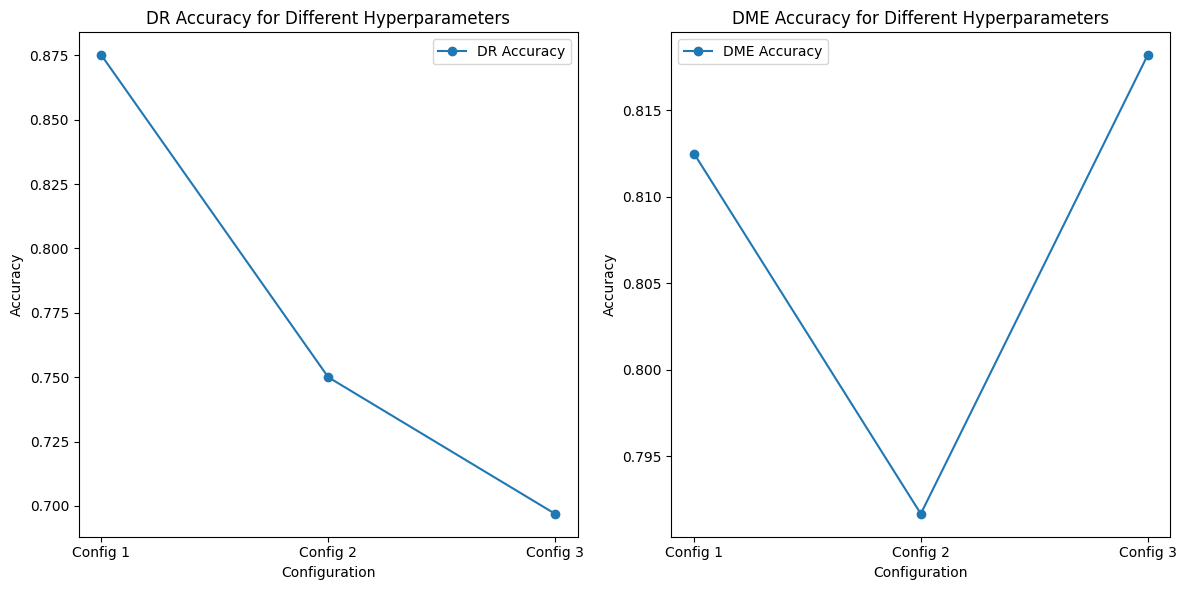

In [ ]:
# Visualizing the accuracies
plt.figure(figsize=(12, 6))

# DR Accuracy
plt.subplot(1, 2, 1)
plt.plot(results_df['DR Accuracy'], label='DR Accuracy', marker='o')
plt.title('DR Accuracy for Different Hyperparameters')
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.xticks(range(len(results_df)), labels=[f"Config {i+1}" for i in range(len(results_df))])
plt.legend()

# DME Accuracy
plt.subplot(1, 2, 2)
plt.plot(results_df['DME Accuracy'], label='DME Accuracy', marker='o')
plt.title('DME Accuracy for Different Hyperparameters')
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.xticks(range(len(results_df)), labels=[f"Config {i+1}" for i in range(len(results_df))])
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Displaying the table with the results
print("Hyperparameters and Accuracies Table:")
display(results_df)

Hyperparameters and Accuracies Table:


,Test Size,Learning Rate,Epochs,DR Accuracy,DME Accuracy
0,0.2,0.0001,20.0,0.87500,0.812500
1,0.3,0.0005,30.0,0.75000,0.791667
2,0.4,0.0002,50.0,0.69697,0.818182


In [ ]:
from keras.models import load_model

# Loading the model
model = load_model('hybrid_model.h5')

In [ ]:
from keras.preprocessing import image

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    dr_grade = np.argmax(predictions[0])
    dme_risk = np.argmax(predictions[1])
    return dr_grade, dme_risk

image_path = '/content/IDRiD/Disease Grading/1. Original Images/a. Training Set/IDRiD_008.jpg'
dr_grade, dme_risk = predict(image_path, model)

print(f"DR Grade: {dr_grade}")
print(f"DME Risk: {dme_risk}")

1/1 [==============================] - 2s 2s/step
DR Grade: 2
DME Risk: 0


In [ ]:
def preprocess_image(image_path):
      img = image.load_img(image_path, target_size=(224, 224))
      img_array = image.img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      return img_array

def predict(image_path, model):
      img_array = preprocess_image(image_path)
      predictions = model.predict(img_array)
      dr_grade = np.argmax(predictions[0])
      dme_risk = np.argmax(predictions[1])
      return dr_grade, dme_risk

image_path = '/content/IDRiD/Disease Grading/1. Original Images/a. Training Set/IDRiD_030.jpg'
dr_grade, dme_risk = predict(image_path, model)

print(f"DR Grade: {dr_grade}")
print(f"DME Risk: {dme_risk}")

1/1 [==============================] - 0s 31ms/step
DR Grade: 4
DME Risk: 2


In [ ]:
def preprocess_image(image_path):
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

def predict(image_path, model):
        img_array = preprocess_image(image_path)
        predictions = model.predict(img_array)
        dr_grade = np.argmax(predictions[0])
        dme_risk = np.argmax(predictions[1])
        return dr_grade, dme_risk

image_path = '/content/IDRiD/Disease Grading/1. Original Images/a. Training Set/IDRiD_222.jpg'
dr_grade, dme_risk = predict(image_path, model)

print(f"DR Grade: {dr_grade}")
print(f"DME Risk: {dme_risk}")

1/1 [==============================] - 0s 32ms/step
DR Grade: 0
DME Risk: 2


# Module 4- Textural features

In [ ]:
import pandas as pd

# Assuming the DataFrame is loaded as df
df = pd.read_csv('/content/IDRiD/Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')

# Filtering the DataFrame for DR grade 4
dr_4_df = df[df['Retinopathy grade'] == 4]

# Calculating the probabilities for DME grade 1
dme_1_probability = len(dr_4_df[dr_4_df['Risk of macular edema '] == 0]) / len(dr_4_df) * 100

print(f"Probability of DME being 1 when DR grade is 4: {dme_1_probability:.2f}%")

Probability of DME being 1 when DR grade is 4: 8.16%


In [ ]:
# Creating a dictionary mapping numerical labels to wordings
dr_grade_mapping = {0: 'No DR', 1: 'Mild retinopathy', 2: 'Moderate retinopathy', 3: 'Severe retinopathy', 4: 'Proliferative DR'}
dme_risk_mapping = {0: 'No DME', 1: 'Moderate macular edema', 2: 'Severe macular edema'}

# Replacing numerical labels with wordings
df['Retinopathy grade'] = df['Retinopathy grade'].map(dr_grade_mapping)
df['Risk of macular edema '] = df['Risk of macular edema '].map(dme_risk_mapping)

# Printing the DataFrame with wordings
print(df[['Retinopathy grade', 'Risk of macular edema ',]])

        Retinopathy grade  Risk of macular edema 
0      Severe retinopathy    Severe macular edema
1      Severe retinopathy    Severe macular edema
2    Moderate retinopathy    Severe macular edema
3      Severe retinopathy    Severe macular edema
4        Proliferative DR                  No DME
..                    ...                     ...
408  Moderate retinopathy  Moderate macular edema
409  Moderate retinopathy                  No DME
410  Moderate retinopathy                  No DME
411  Moderate retinopathy                  No DME
412  Moderate retinopathy                  No DME

[413 rows x 2 columns]


In [ ]:
# Filtering the DataFrame for "proliferative DR"
proliferative_dr_df = df[df['Retinopathy grade'] == "Proliferative DR"]

# Calculating the percentage of "moderate macular edema"
mild_macular_edema_percentage = (proliferative_dr_df['Risk of macular edema '].value_counts(normalize=True)*100).get("Moderate macular edema", 0)

print(f"The percentage of 'mild macular edema' when DR grade is 'proliferative DR' is: {mild_macular_edema_percentage:.2f}%")

The percentage of 'mild macular edema' when DR grade is 'proliferative DR' is: 8.16%


In [ ]:
# Filtering the DataFrame for "proliferative DR"
proliferative_dr_df = df[df['Retinopathy grade'] == "Proliferative DR"]

# Calculating the percentage of "severe macular edema"
mild_macular_edema_percentage = (proliferative_dr_df['Risk of macular edema '].value_counts(normalize=True)*100).get("Severe macular edema", 0)

print(f"The percentage of 'Severe macular edema' when DR grade is 'proliferative DR' is: {mild_macular_edema_percentage:.2f}%")

The percentage of 'Severe macular edema' when DR grade is 'proliferative DR' is: 83.67%


In [ ]:
# Filtering the DataFrame for "proliferative DR"
proliferative_dr_df = df[df['Retinopathy grade'] == "No DR"]

# Calculating the percentage of "mild macular edema"
mild_macular_edema_percentage = (proliferative_dr_df['Risk of macular edema '].value_counts(normalize=True)*100).get("No DME", 0)

print(f"The percentage of 'mild macular edema' when DR grade is 'No DR' is: {mild_macular_edema_percentage:.2f}%")

The percentage of 'mild macular edema' when DR grade is 'No DR' is: 100.00%


In [ ]:
import os
import shutil

# Defining the path to the original images folder
original_images_folder = '/content/IDRiD/Disease Grading/1. Original Images/a. Training Set'

# Defining the path to the subset folder where the images will be copied
subset_folder = '/content/IDRiD/Disease Grading/1. Original Images/New dataset'

# Filtering the DataFrame for the specified conditions
subset_df = df[((df['Retinopathy grade'] == 'Proliferative DR') & (df['Risk of macular edema '] == 'Moderate macular edema')) |
                ((df['Retinopathy grade'] == 'No DR') & (df['Risk of macular edema '] == 'No DME'))]

# Creating the subset folder if it doesn't exist
if not os.path.exists(subset_folder):
    os.makedirs(subset_folder)

# Copying the images that meet the conditions to the subset folder
for index, row in subset_df.iterrows():
    image_name = row['Image name'] + '.jpg'  # Assuming the image names include the file extension
    source_path = os.path.join(original_images_folder, image_name)
    destination_path = os.path.join(subset_folder, image_name)
    shutil.copyfile(source_path, destination_path)

print("Subset folder created.")

Subset folder created.


In [ ]:
subset_folder = '/content/IDRiD/Disease Grading/1. Original Images/New dataset'

# Listing all files in the subset folder
files = os.listdir(subset_folder)

# Filtering only files with .jpg extension
image_files = [file for file in files if file.endswith('.jpg')]

# Counting the number of image files
num_images = len(image_files)

print(f"Number of images in subset folder: {num_images}")

Number of images in subset folder: 138


In [ ]:
# Path to the CSV file containing all labels
labels_file = '/content/IDRiD/Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'

# Path to the folder containing the 138 image files
images_folder = '/content/IDRiD/Disease Grading/1. Original Images/New dataset'

# Getting the list of image file names in the folder
image_files = os.listdir(images_folder)
image_files = [file.split('.')[0] for file in image_files]  # Remove the file extension

# Reading the full labels CSV file
full_labels_df = pd.read_csv(labels_file)

# Creating a subset DataFrame containing only the rows corresponding to the image files in the folder
subset_labels_df = full_labels_df[full_labels_df['Image name'].isin(image_files)]

# Saving the subset DataFrame to a new CSV file
subset_labels_file = '/content/IDRiD/Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Subset.csv'
subset_labels_df.to_csv(subset_labels_file, index=False)

**Contrast**: Measures the local variations in the image. High contrast values indicate that there are large intensity differences between neighboring pixels, while low contrast values indicate more uniform regions.

**Dissimilarity**: Similar to contrast but considers the absolute differences between pixel intensities rather than squared differences. It measures the average absolute difference in intensity between neighboring pixels.

**Homogeneity**: Also known as inverse difference moment, it measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal. High homogeneity values indicate that the image region has a more uniform texture.

**Energy**: Represents the sum of squared elements in the GLCM. It is a measure of the texture's uniformity. High energy values indicate a more uniform texture.

**Correlation**: Measures the linear dependency of gray levels between neighboring pixels in the image. It indicates the level of correlation between the pixels' intensities.

In [ ]:
from skimage import io
from skimage.feature import greycomatrix, greycoprops
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Loading the CSV file containing image filenames and labels
df = pd.read_csv('/content/IDRiD/Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Subset.csv')

# Assuming the dataset has columns 'image_name', 'DR_grade', 'DME_risk'
df['Image name'] = df['Image name'].apply(lambda x: f"/content/IDRiD/Disease Grading/1. Original Images/New dataset/{x}.jpg")

# Spliting the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
def extract_texture_features(image_path):
    # Loading the image
    image = io.imread(image_path, as_gray=True)

    # Converting image to unsigned integer type
    image_uint = (image * 255).astype(np.uint8)

    # Computing GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = greycomatrix(image_uint, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Computing GLCM properties
    contrast = greycoprops(glcm, 'contrast').mean()
    dissimilarity = greycoprops(glcm, 'dissimilarity').mean()
    homogeneity = greycoprops(glcm, 'homogeneity').mean()
    energy = greycoprops(glcm, 'energy').mean()
    correlation = greycoprops(glcm, 'correlation').mean()

    return [contrast, dissimilarity, homogeneity, energy, correlation]

In [ ]:
# Extracting features and labels for training set
X_train = []
y_train = []
for index, row in train_df.iterrows():
    image_path = row['Image name']
    features = extract_texture_features(image_path)
    X_train.append(features)
    y_train.append(row['Retinopathy grade'])

# Extracting features and labels for validation set
X_val = []
y_val = []
for index, row in val_df.iterrows():
    image_path = row['Image name']
    features = extract_texture_features(image_path)
    X_val.append(features)
    y_val.append(row['Retinopathy grade'])

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [ ]:
# Training SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluating the classifier
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
# Show 5 sample images for each GLCM property
properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
for prop in properties:
    print(f"Top 5 images for {prop}:")
    count = 0
    for index, features in enumerate(X_val):
        if count < 5:
            image_path = val_df.iloc[index]['Image name']
            image = io.imread(image_path)
            prop_value = features[properties.index(prop)]
            print(f"Image {index}: {prop}={prop_value}")
            io.imshow(image)
            io.show()
            count += 1